In [1]:
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

#%matplotlib notebook

In [2]:
data_dir = "../data/Clear sky/Varennes/"
generate_data = True

if generate_data:
    files = sorted([file for (_, _, files) in os.walk(data_dir) for file in files if ".csv" in file and not file.startswith(".") ])

    data = None
    for file in files:
        file_df = pd.read_csv(os.path.join(data_dir, file))
        file_df = file_df[file_df.columns[[0,1,2]]]
        file_df.columns = ["date", "timestamp", file.split("_")[-1].split(".")[0]]   
        file_df.index = [file_df.pop(c) for c in ["date", "timestamp"]]

        if data is None:
            data = file_df
        else:
            data = pd.concat([data,file_df], axis=1, sort=False)

    
    data = data.fillna(method='ffill')
    data.to_csv(os.path.join(data_dir, "../", os.path.basename(os.path.normpath(data_dir))+".csv"))
    
    
data = pd.read_csv(os.path.join(data_dir, "../", os.path.basename(os.path.normpath(data_dir))+".csv"), index_col=[0,1])

cloud_cover = os.path.basename(os.path.normpath(data_dir+"../"))
site = os.path.basename(os.path.normpath(data_dir))

t0 = datetime.strptime(data.index[0][0]+data.index[0][1], "%Y-%m-%d%H:%M:%S.%f")
tf = datetime.strptime(data.index[-1][0]+data.index[-1][1], "%Y-%m-%d%H:%M:%S.%f")
duration = tf-t0
duration_seconds = duration.total_seconds()
print("Duration: {}:{}:{}".format(int(duration_seconds//3600), int((duration_seconds%3600)//60), int((duration_seconds%3600)%60)))

data

Duration: 9:50:0


VAR01  VAR02  VAR03  VAR04  VAR05  VAR06  VAR07  \
date       timestamp                                                       
2014-12-30 07:01:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           07:02:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           07:03:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           07:04:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           07:05:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...                        ...    ...    ...    ...    ...    ...    ...   
           16:47:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           16:48:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           16:49:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           16:50:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           16:51:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                         VAR08  VAR09  VAR10  VAR11  VAR12  VAR13  VAR14  \
date       timestamp                                                       
2014-12-30 07:01:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           07:02:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           07:03:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           07:04:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           07:05:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...                        ...    ...    ...    ...    ...    ...    ...   
           16:47:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           16:48:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           16:49:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           16:50:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           16:51:00.000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                         VAR15  VAR16  VAR17  
date       timestamp                          
2014-12-30 07:01:00.000    0.0    0.0    0.0  
           07:02:00.000    0.0    0.0    0.0  
           07:03:00.000    0.0    0.0    0.0  
           07:04:00.000    0.0    0.0    0.0  
           07:05:00.000    0.0    0.0    0.0  
...                        ...    ...    ...  
           16:47:00.000    0.0    0.0    0.0  
           16:48:00.000    0.0    0.0    0.0  
           16:49:00.000    0.0    0.0    0.0  
           16:50:00.000    0.0    0.0    0.0  
           16:51:00.000    0.0    0.0    0.0  

[76389 rows x 17 columns]

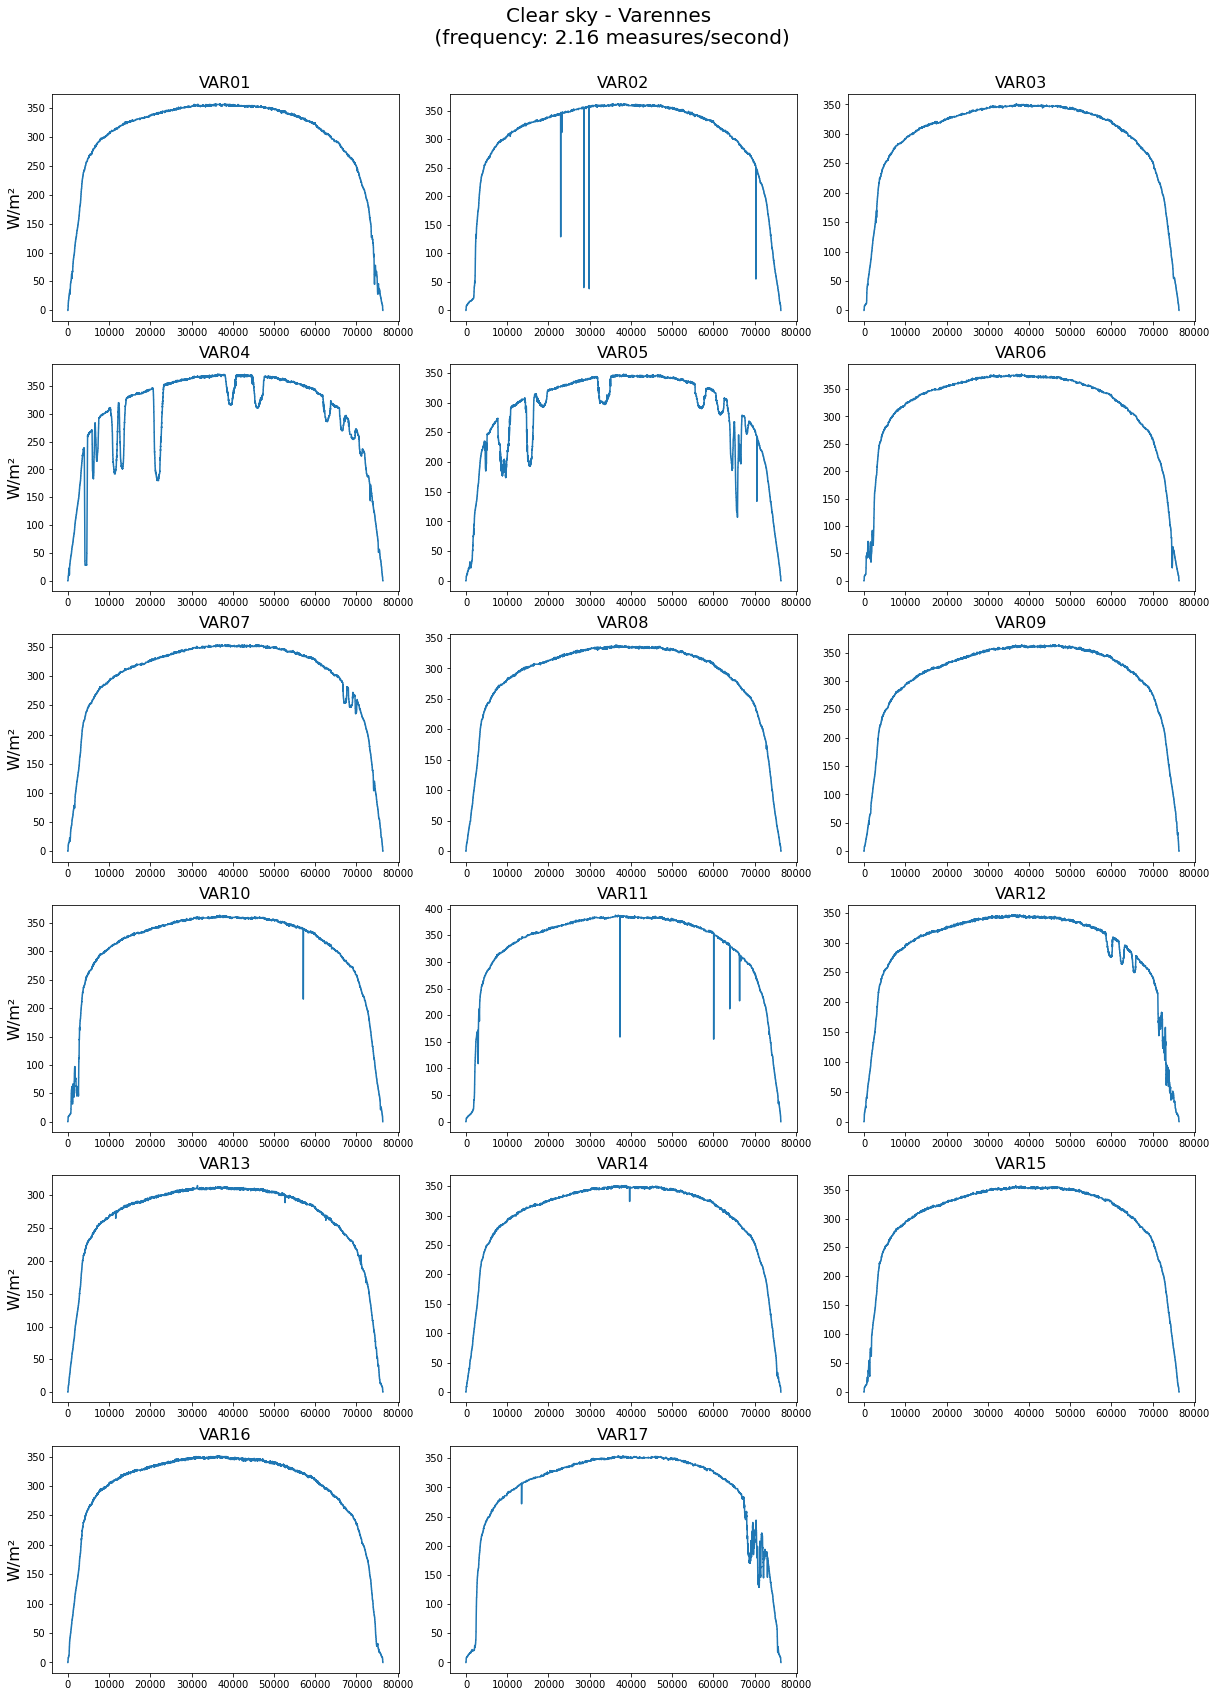

In [3]:
n_rows = len(data.columns)//3 + (1 if len(data.columns)%3!=0 else 0)
fig, ax = plt.subplots(n_rows, 3, figsize=(17,n_rows*4))
ax = ax.flatten()
for i, unit in enumerate(data.columns):
    ax[i].plot(data[unit].values)
    ax[i].set_title(unit, size=16)
    if i%3==0:
        ax[i].set_ylabel("W/m²", size=16)
    
if len(data.columns)%3==2:
    fig.delaxes(ax[-1])
if len(data.columns)%3==1:
    fig.delaxes(ax[-1])
    fig.delaxes(ax[-2])
    
fig.suptitle("{} - {}\n (frequency: {:.2f} measures/second)".format(cloud_cover, site, len(data)/duration_seconds), size=20)


fig.tight_layout()
fig.subplots_adjust(top=0.93)

plt.savefig("../images/data/{}_{}.jpg".format(site,cloud_cover))
plt.show()

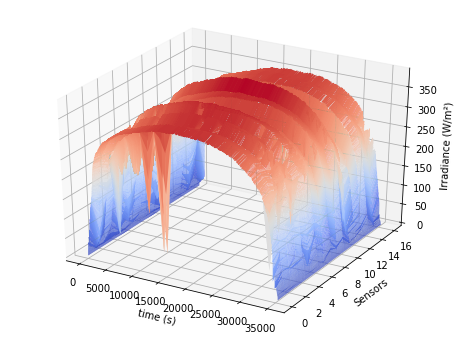

In [4]:
x = np.linspace(0,duration_seconds, len(data))
y = np.array([i for i in range(len(data.columns))], dtype="float32")

X, Y = np.meshgrid(x, y)
Z = data.values.T.astype(dtype="float32")

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.set_xlabel("time (s)")
ax.set_ylabel("Sensors")
ax.set_zlabel("Irradiance (W/m²)")
plt.show()

In [5]:
timeseries_period = 100 #milliseconds
timestamps = [t0 + i*timedelta(milliseconds=timeseries_period) for i in range(int(duration_seconds*1000/timeseries_period))]
timeseries_data = pd.DataFrame(index=timestamps, columns=data.columns)
i = 0
prev_value = data.iloc[i]
for ts in timestamps:
    for j in range(i, len(data)):
        row = data.iloc[j]
        row_t = datetime.strptime(row.name[0]+row.name[1], "%Y-%m-%d%H:%M:%S.%f")
        if row_t < ts:
            prev_value = row.values
            i+=1
        elif row_t == ts:
            prev_value = row.values
            i+=1
            break
        elif row_t > ts:
            break
    timeseries_data.loc[ts] = prev_value

initial_zeros = 0
for i in range(len(timeseries_data)):
    if np.sum(timeseries_data.iloc[i].values)>0:
        break
    initial_zeros += 1

final_zeros = 0
for i in range(len(timeseries_data)-1, -1, -1):
    if np.sum(timeseries_data.iloc[i].values)>0:
        break
    final_zeros += 1
    
    
timeseries_data = timeseries_data.iloc[initial_zeros:-final_zeros]
timeseries_data.to_csv(os.path.join(data_dir, "../", os.path.basename(os.path.normpath(data_dir))+"_{}ms.csv".format(timeseries_period)))


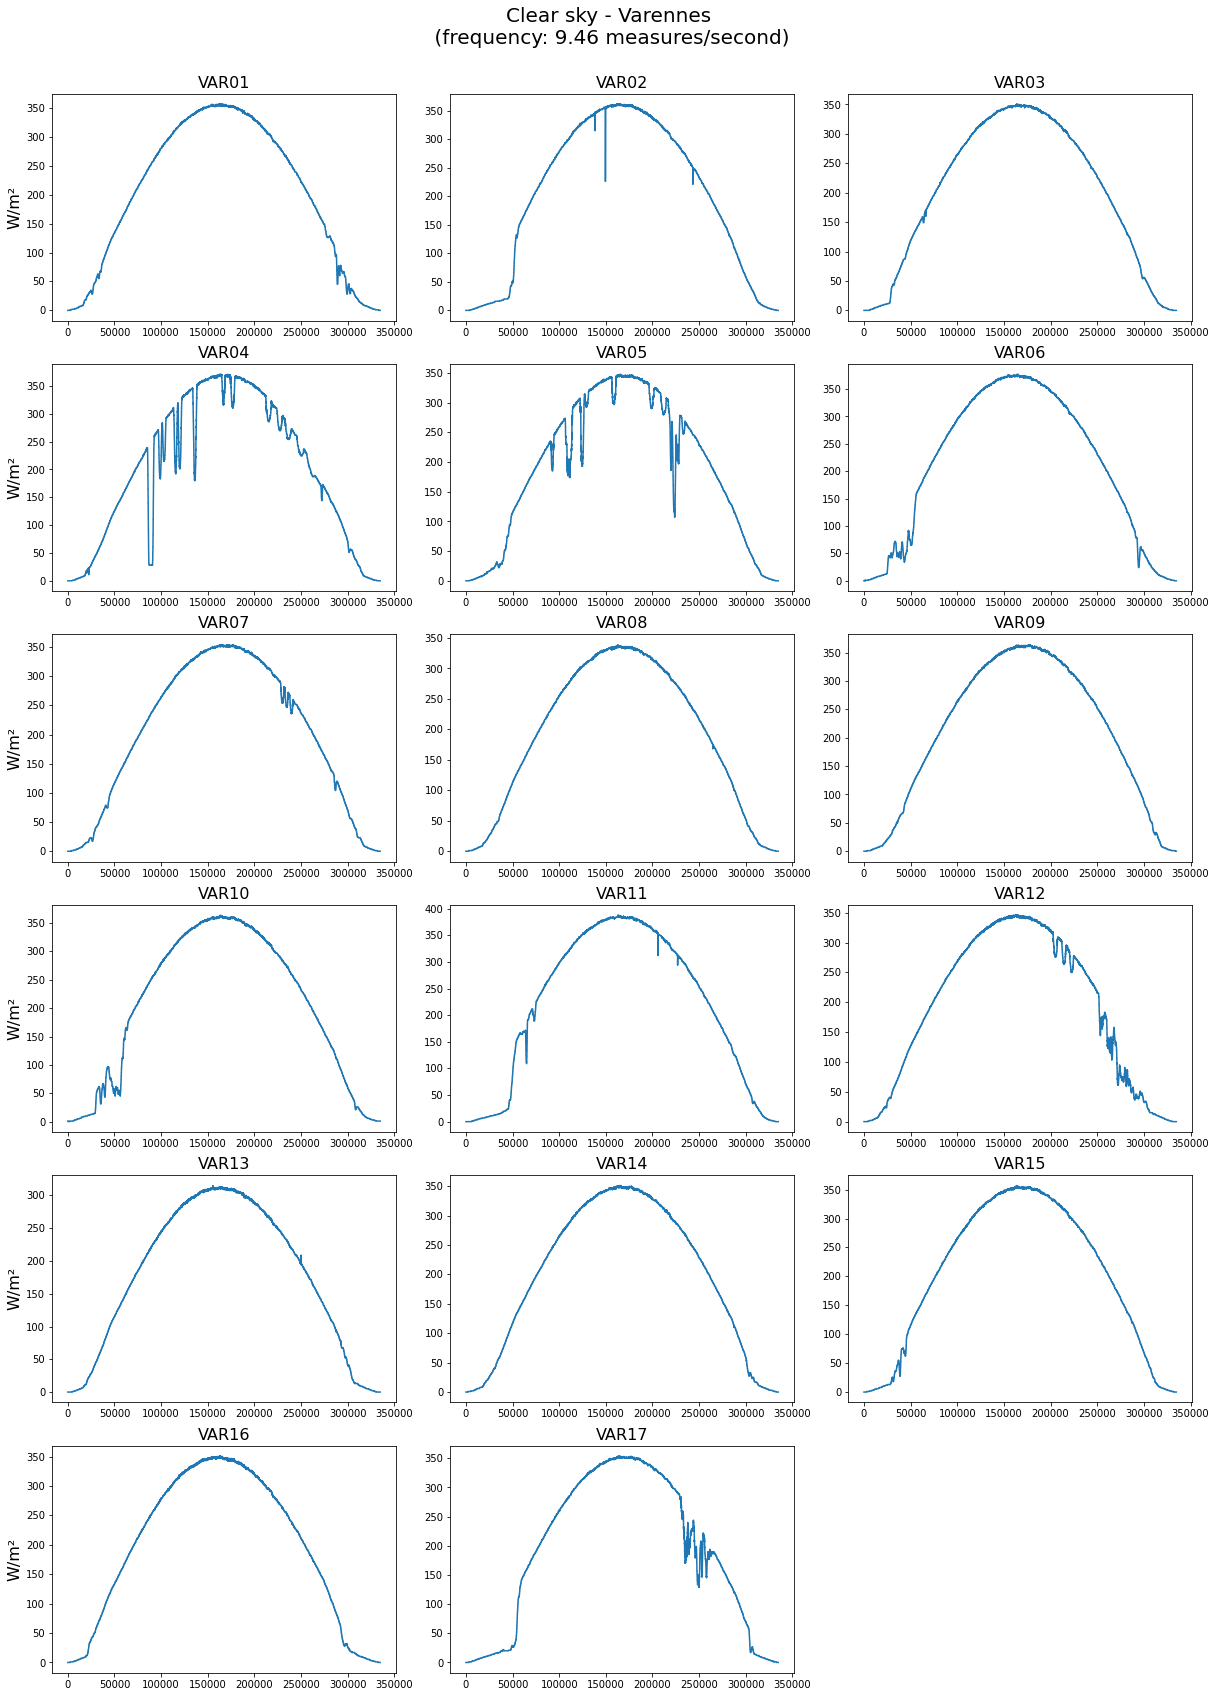

In [6]:
n_rows = len(timeseries_data.columns)//3 + (1 if len(timeseries_data.columns)%3!=0 else 0)
fig, ax = plt.subplots(n_rows, 3, figsize=(17,n_rows*4))
ax = ax.flatten()
for i, unit in enumerate(timeseries_data.columns):
    ax[i].plot(timeseries_data[unit].values)
    ax[i].set_title(unit, size=16)
    if i%3==0:
        ax[i].set_ylabel("W/m²", size=16)
    
if len(timeseries_data.columns)%3==2:
    fig.delaxes(ax[-1])
if len(timeseries_data.columns)%3==1:
    fig.delaxes(ax[-1])
    fig.delaxes(ax[-2])
    
fig.suptitle("{} - {}\n (frequency: {:.2f} measures/second)".format(cloud_cover, site, len(timeseries_data)/duration_seconds), size=20)


fig.tight_layout()
fig.subplots_adjust(top=0.93)

plt.savefig("../images/data/{}_{}.jpg".format(site,cloud_cover))
plt.show()

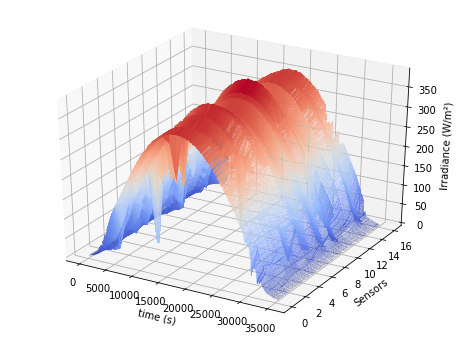

In [7]:
x = np.linspace(0,duration_seconds, len(timeseries_data))
y = np.array([i for i in range(len(timeseries_data.columns))], dtype="float32")

X, Y = np.meshgrid(x, y)
Z = timeseries_data.values.T.astype(dtype="float32")

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.set_xlabel("time (s)")
ax.set_ylabel("Sensors")
ax.set_zlabel("Irradiance (W/m²)")
plt.show()